**☀️ Welcome to ParkerNet Version 1.0 Notebook 1 of 3!**

This notebook can be used to recreate the learning steps (e.g., training) of ParkerNet. ParkerNet Version 1.0 uses data from FIELDS (4s per cycle L2 data) and SPC (L3 data). FIELDS and SWEAP (SPC) data can be obtained from CDAWeb. FIELDS data were downsampled to 0.8738s and time synchronized with SPC data. If SPC data contained data gaps more than 25 minutes in an hour window, that window was discarded from the full dataset. The provided text file (PSP_E1toE7_july23_nonoise.txt) has already undergone these steps.

**All datasets MUST have the exact time resolution and input variables for ParkerNet to run correctly (keep this mind if you want to test ParkerNet on new data not accompanying the publication).**

*This notebook is, notebook 1 of the 3 accompanying notebooks needed to reproduce the results in the Paper titled "An Iterative, Deep Learning Approach for Switchback Classification in Parker Solar Probe Data ".*


***With this notebook, you will be able to:***

1.train ParkerNet for 3 different splits (split M, split N, split P) for various seeds.

2.save ParkerNet model weights

3.evaluate parkernet on the validation set and plot evaluation metrics (e.g., PRC curve).

4.try out a prediction on the test set



***Notes: The training set (i.e., file "PSP_E1toE7_July23_nonoise.txt" ) has already gone through the incremental , targeted-HITL (human-in-the-loop) procedure. You will only be recreating the final training and not the targeted-HITL approach.***




** Package Versions** This notebook was implemented in a high compute (A100 GPU) Google Colab environment. The requirement.txt package is difficult to use due to this, but we have printed the version of packages used in the project within this notebook. This should help with any package/version issues.

Files needed to run notebook:

"PSP_E1toE7_July23_nonoise.txt"

*Optional files that were used for additional validation (check for how well ParkerNet is doing, mainly used in iterative training).*

"PSP_E15.txt"



# ====== Load Packages ======


________________________________________________________________________________________________________________________________________________________________

We will start by loading all the packages we will need for this project.

In [ ]:
import pandas as pd
import os
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D,Activation, Dense, Dropout, Flatten, TimeDistributed, Bidirectional, LSTM, GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import  Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score, auc
from sklearn.metrics import precision_recall_curve, auc
from keras import initializers
import tensorflow as tf
import random

In [ ]:
# Print versions
print("Versions of installed libraries:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"keras: {keras.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"matplotlib: {plt.matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"scikit-learn: {sns.__version__}")

Versions of installed libraries:
pandas: 2.2.2
numpy: 1.26.4
keras: 3.8.0
tensorflow: 2.18.0
matplotlib: 3.10.0
seaborn: 0.13.2
scikit-learn: 0.13.2


When running this notebook locally, ignore the google drive specific commands and simply read in the provided .txt files needed from your local folder.

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
cd MyDrive/MyDrive

/content/MyDrive/MyDrive


# ====== Load data ======

Loading in the file that will be used for training and validation.

In [ ]:
df = pd.read_csv('PSP_E1toE7_July23_nonoise.txt', sep = "\t", parse_dates=['Datetime'],#PSP_E1toE7_July23_nonoise.txt
                 infer_datetime_format=True,
                 index_col='Datetime',)

Class= df['Class'].astype('int')
df.Class = df.Class.replace({True: 1, False: 0})
df.pop("indices")
df.pop("Encounter")
X_HCI_train = df.pop("X_HCI")
Y_HCI_train = df.pop("Y_HCI")
Z_HCI_train = df.pop("Z_HCI")
#ProtonDensity_train = df.pop("ProtonDensity")
df.pop("Dist")
#df.pop("Vmag")
#df.pop("Bmag")
#df.pop("V_nr")
#df.pop("B_t")
#df.pop("B_n")
#df.pop("V_n")
#df.pop("V_t")
df.head()

<ipython-input-10-7fc5df52942e>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('PSP_E1toE7_July23_nonoise.txt', sep = "\t", parse_dates=['Datetime'],#PSP_E1toE7_July23_nonoise.txt
<ipython-input-10-7fc5df52942e>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.Class = df.Class.replace({True: 1, False: 0})


,B_r,Bmag,B_t,B_n,V_r,V_t,V_n,Vmag,V_nr,ProtonDensity,Class
Datetime,,,,,,,,,,,
2018-11-04 00:00:00.000,-66.058226,70.255204,-4.140612,-23.557585,267.886,-28.3115,-39.9285,272.321015,48.947177,391.665,0
2018-11-04 00:00:00.873,-65.699724,70.171543,-3.381591,-24.416317,263.905,-69.5283,-43.8579,276.411919,82.205230,536.104,0
2018-11-04 00:00:01.747,-66.442084,70.452417,-8.469396,-21.846322,266.871,-41.5544,-24.7354,271.217143,48.359158,367.138,0
2018-11-04 00:00:02.621,-65.771892,70.127234,-15.798794,-18.500954,260.689,-57.2835,-41.0414,270.045460,70.468403,504.809,0
2018-11-04 00:00:03.495,-64.232595,70.390542,-18.842718,-21.770487,267.265,-26.0570,-45.9163,272.429540,52.794639,394.882,0


**IMPORTANT: All dataframes MUST have the exact number of columns and variables in the same order.**

Optional file: load this in if you want to do additional evaluations on ParkerNet predictions

In [ ]:
df_eval = pd.read_csv('PSP_E15.txt', sep = "\t", parse_dates=['Datetime'],
                 infer_datetime_format=True,
                 index_col='Datetime',)

Class= df_eval['Class'].astype('int')
df_eval.Class = df_eval.Class.replace({True: 1, False: 0})
df_eval.pop("indices")
df_eval.pop("Dist")
#df_eval.pop("Vmag")
#df_eval.pop("Bmag")
#df_eval.pop("B_n")
#df_eval.pop("B_t")
#df_eval.pop("V_nr")
#df_eval.pop("V_t")
#df_eval.pop("V_n")
df_eval.pop("X_HCI")
df_eval.pop("Y_HCI")
df_eval.pop("Z_HCI")
#ProtonDensity_test = df_eval.pop("ProtonDensity")
df_eval.head()

<ipython-input-11-976ce052e2a5>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_eval = pd.read_csv('PSP_E15.txt', sep = "\t", parse_dates=['Datetime'],
<ipython-input-11-976ce052e2a5>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eval.Class = df_eval.Class.replace({True: 1, False: 0})


,B_r,Bmag,B_t,B_n,V_r,V_t,V_n,Vmag,V_nr,ProtonDensity,Class
Datetime,,,,,,,,,,,
2023-03-14 00:00:00.000000000,119.634033,126.446237,-33.865352,-23.010583,436.554,-7.60553,88.2408,445.447727,88.567956,15.8135,0
2023-03-14 00:00:00.873799999,118.104463,125.810862,-26.227469,-34.522871,436.554,-7.60553,88.2408,445.447727,88.567956,15.8135,0
2023-03-14 00:00:01.747599999,117.741037,124.677655,-32.991824,-24.353753,436.554,-7.60553,88.2408,445.447727,88.567956,15.8135,0
2023-03-14 00:00:02.621399999,120.912992,125.529900,-32.727764,-8.166860,436.554,-7.60553,88.2408,445.447727,88.567956,15.8135,0
2023-03-14 00:00:03.495199999,119.837041,125.240096,-32.149696,-17.045884,436.554,-7.60553,88.2408,445.447727,88.567956,15.8135,0


# ====== Create Data Splits : Train -Val - Test ======

Splitting the dataset into various train-validation-test splits.

# **Split M**



| **Split M has data from the following dates** |
|---------------------------|
| 2018-11-04 |
| 2018-11-05 |
| 2018-11-06 |
| 2018-11-07 |
| 2018-11-08 |
| 2019-04-02 |
| 2019-04-03 |
| 2019-04-04 |
| 2019-04-05 |
| 2019-04-06 |
| 2019-04-07 |
| 2019-08-26 |
| 2019-08-27 |
| 2019-08-28 |
| 2019-08-29 |
| 2019-08-30 |
| 2019-08-31 |
| 2020-01-27 |
| 2020-01-28 |
| 2020-01-29 |
| 2020-01-31 |
| 2020-02-01 |


In [ ]:
#test M`, train: E1 to E4, val:E5-E6 EOD Sept 23, test 1:E6 Sept 24 + E7 , test2: E15
Xtrain = df.iloc[0:1615023,:-1] #everything but the last column (split1)
ytrain = df.iloc[0:1615023,-1]#only pick the last column
Xval = df.iloc[1615023:1788065,:-1] #everything but the last column (split 1)
yval = df.iloc[1615023:1788065,-1]#only pick the last column
Xtest1 = df.iloc[1788065:,:-1] #everything but the last column
ytest1 = df.iloc[1788065:,-1]#only pick the last column

# **Split N**

| **Split N has data from the following dates** |
|---------------------------|
| 2018-11-04 |
| 2018-11-05 |
| 2018-11-06 |
| 2018-11-07 |
| 2018-11-08 |
| 2019-04-02 |
| 2019-04-03 |
| 2019-04-04 |
| 2019-04-05 |
| 2019-04-06 |
| 2019-04-07 |
| 2019-08-26 |
| 2019-08-27 |
| 2019-08-28 |
| 2019-08-29 |
| 2019-08-30 |
| 2019-08-31 |


In [ ]:
#test N`, train: E1 to E3, val:E4-E6 EOD Sept 23, test 1:E6 Sept 24 + E7 , test2: E15
Xtrain = df.iloc[0:1338985,:-1] #everything but the last column (split1)
ytrain = df.iloc[0:1338985,-1]#only pick the last column
Xval = df.iloc[1338985:1788065,:-1] #everything but the last column (split 1)
yval = df.iloc[1338985:1788065,-1]#only pick the last column
Xtest1 = df.iloc[1788065:,:-1] #everything but the last column
ytest1 = df.iloc[1788065:,-1]#only pick the last column

# **Split P**

| **Split N has data from the following dates** |
|---------------------------|
| 2019-08-26 |
| 2019-08-27 |
| 2019-08-28 |
| 2019-08-29 |
| 2019-08-30 |
| 2019-08-31 |
| 2020-01-27 |
| 2020-01-28 |
| 2020-01-29 |
| 2020-01-31 |
| 2020-02-01 |

   

In [ ]:
#test P`, train: E3 to E4, val:E5-E6 EOD SEPT 23, test 1:E6 Sept 24 + E7 , test2: E15
Xtrain = df.iloc[786732:1615023,:-1] #everything but the last column (split1)
ytrain = df.iloc[786732:1615023,-1]#only pick the last column
Xval = df.iloc[1615023:1788065,:-1] #everything but the last column (split 1)
yval = df.iloc[1615023:1788065,-1]#only pick the last column
Xtest1 = df.iloc[1788065:,:-1] #everything but the last column
ytest1 = df.iloc[1788065:,-1]#only pick the last column

In [ ]:
#uncomment these if you want to test how well ParkerNet does in additional datasets

#Xtest2 = df_eval.iloc[:,:-1] #everything but the last column
#ytest2 = df_eval.iloc[:,-1]#only pick the last column



Quick check to see the amount of positive (switchback) cases in each split

In [ ]:
neg, pos = np.bincount(ytrain)
total = neg + pos
print('Examples in Train Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(yval)
total = neg + pos
print('Examples in Val Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(ytest1)
total = neg + pos
print('Examples in Test set 1 Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

neg, pos = np.bincount(ytest2)
total = neg + pos
print('Examples in Test set 2 Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples in Train Set:
    Total: 1615023
    Positive: 195085 (12.08% of total)

Examples in Val Set:
    Total: 173042
    Positive: 45574 (26.34% of total)

Examples in Test set 1 Set:
    Total: 230718
    Positive: 56357 (24.43% of total)

Examples in Test set 2 Set:
    Total: 197758
    Positive: 30622 (15.48% of total)



# ====== Data Normalization ======

Z-score normalization. Note that the mean and std of the TRAIN SET is used for all sets. This is to avoid data leakage; the network must not know anything about future information.

In [ ]:
train_mean = Xtrain.mean()
train_std = Xtrain.std()

train_df = (Xtrain - train_mean) / train_std
val_df = (Xval - train_mean) / train_std
test_df = (Xtest1 - train_mean) / train_std
#uncomment the following code if you want to play around with the optional datasets
#eval_df = (Xtest2 - train_mean) / train_std


# ====== Create Data Sequences ======

Since ParkerNet contains a sequence learning component (LSTM) we need to convert the data into sequences. After hyperparameter tuning, the best sequence length was found to be 50.

In [ ]:
def split_sequences_nolags(dataset,labels, time_steps):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset.iloc[i:(i+time_steps)]
        data_X.append(a)
        data_Y.append(labels.iloc[i:i + time_steps])
    return np.array(data_X), np.array(data_Y)

In [ ]:
train_features_new, train_labels_new = split_sequences_nolags(train_df,ytrain,50) #originally 343, previously:90, tried: 72, 25, current: 50
val_features_new, val_labels_new = split_sequences_nolags(val_df,yval,50)
test_features_new, test_labels_new = split_sequences_nolags(test_df,ytest1,50)
#eval_features_new, eval_labels_new = split_sequences_nolags(eval_df,ytest2,50) #uncomment if you want to use the optional files

n_timesteps, n_features, n_outputs = train_features_new.shape[1],train_features_new.shape[2],train_labels_new.shape[1]
train_labels_new= train_labels_new.astype('float64')
val_labels_new = val_labels_new.astype('float64')
test_labels_new = test_labels_new.astype('float64')
#eval_labels_new = eval_labels_new.astype('float64') #uncomment if using optional files

# ====== Setting up ParkerNet ======

Custom Binary Cross Entropy Loss Function. This modifies the regular binary cross entropy function to weigh the positive class more.

In [ ]:
POS_WEIGHT = 200
POS_WEIGHT = POS_WEIGHT

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor
    and a target tensor. POS_WEIGHT is used as a multiplier
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tf.convert_to_tensor(tf.keras.backend.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target, logits=output, pos_weight=POS_WEIGHT)

    return tf.reduce_mean(loss, axis=-1)

Metrics for evaluation when training

In [ ]:
METRICS = [
    keras.metrics.Precision(name = 'precision'),
    keras.metrics.Recall(name = 'recall')
]

METRICS1 = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# ====== Training Section ======


This section trains the final models for the various splits. The best POS weight, learning rate, layer numbers, CNN kernel size, LSTM neuron numbers etc were determined via hyperparameter tuning using Optuna.

TRAINING SPLIT M

In [ ]:
#SPLIT M

# Set seed for reproducibility, remember to set seed IN THE CELL YOU ARE RUNNING THE TRAINING.
my_seed = 3364
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
keras.utils.set_random_seed(my_seed)

initializer_He = keras.initializers.HeNormal(seed=my_seed)
initializer_Glorot = keras.initializers.GlorotUniform(seed=my_seed)
POS_WEIGHT = 8

# Define the model
model4 = Sequential([
    Input(shape=(n_timesteps, n_features)),  # Explicit input layer

    Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', kernel_initializer=initializer_He),
    MaxPooling1D(1),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer=initializer_He),
    MaxPooling1D(1),
    Dropout(0.5),

    Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', kernel_initializer=initializer_He),
    MaxPooling1D(1),

    Bidirectional(LSTM(24, return_sequences=True, kernel_initializer=initializer_Glorot)),
    Dropout(0.3),

    Bidirectional(LSTM(25, return_sequences=True, kernel_initializer=initializer_Glorot)),
    Dropout(0.4),

    Bidirectional(LSTM(45, return_sequences=True, kernel_initializer=initializer_Glorot)),

    Dense(1, activation='sigmoid')
])

# Compile the model
model4.compile(
    loss=weighted_binary_crossentropy,
    optimizer=Adam(learning_rate=4e-07),
    metrics=METRICS1
)

# Define callbacks
cb1_model4 = keras.callbacks.ModelCheckpoint(
    "ParkerNet_ApJ_trialtest.keras", save_best_only=True, monitor="val_loss", mode="min"
)
cb2_model4 = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

# Train the model
history_model4 = model4.fit(
    train_features_new, train_labels_new,
    epochs=60,
    batch_size=1024,
    validation_data=(val_features_new, val_labels_new),
    callbacks=[cb1_model4, cb2_model4],
    shuffle=False,
    verbose=1
)

In [ ]:
#model4.save('ParkerNet_date_splitM_seed3364.keras') #uncomment for saving model and add the date for the date which you ran the model

In [ ]:
#use this if you want to save training history into a .csv file
hist_df = pd.DataFrame(history_model4.history)
hist_csv_file = 'history_date_splitM_seed3364.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

TRAINING SPLIT N

In [ ]:
#splitN
# Set seed for reproducibility
my_seed = 400
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
keras.utils.set_random_seed(my_seed)

initializer_He = keras.initializers.HeNormal(seed=my_seed)
initializer_Glorot = keras.initializers.GlorotUniform(seed=my_seed)
POS_WEIGHT = 8

# Define the model
model4 = Sequential([
    Input(shape=(n_timesteps, n_features)),  # Explicit input layer

    Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'),
    Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', kernel_initializer=initializer_He),
    MaxPooling1D(1),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer=initializer_He),
    MaxPooling1D(1),
    Dropout(0.5),

    Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', kernel_initializer=initializer_He),
    MaxPooling1D(1),

    Bidirectional(LSTM(24, return_sequences=True, kernel_initializer=initializer_Glorot)),
    Dropout(0.3),

    Bidirectional(LSTM(25, return_sequences=True, kernel_initializer=initializer_Glorot)),
    Dropout(0.4),

    Bidirectional(LSTM(45, return_sequences=True, kernel_initializer=initializer_Glorot)),

    Dense(1, activation='sigmoid')
])

# Compile the model
model4.compile(
    loss=weighted_binary_crossentropy,
    optimizer=Adam(learning_rate=4e-07),
    metrics=METRICS1
)

# Define callbacks
cb1_model4 = keras.callbacks.ModelCheckpoint(
    "ParkerNet_splitN_test.keras", save_best_only=True, monitor="val_loss", mode="min"
)
cb2_model4 = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

# Train the model
history_model4 = model4.fit(
    train_features_new, train_labels_new,
    epochs=5,
    batch_size=1024,
    validation_data=(val_features_new, val_labels_new),
    callbacks=[cb1_model4, cb2_model4],
    shuffle=False,
    verbose=1
)


TRAINING SPLIT P

In [ ]:
#Split P
# Set seed for reproducibility
my_seed = 1953
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)
keras.utils.set_random_seed(my_seed)

initializer_He = keras.initializers.HeNormal(seed=my_seed)
initializer_Glorot = keras.initializers.GlorotUniform(seed=my_seed)
POS_WEIGHT = 8

# Define the model
model4 = Sequential([
    Input(shape=(n_timesteps, n_features)),  # Explicit input layer

    Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'),
    Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', kernel_initializer=initializer_He),
    MaxPooling1D(1),
    Dropout(0.2),

    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer=initializer_He),
    MaxPooling1D(1),
    Dropout(0.5),

    Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', kernel_initializer=initializer_He),
    MaxPooling1D(1),

    Bidirectional(LSTM(24, return_sequences=True, kernel_initializer=initializer_Glorot)),
    Dropout(0.3),

    Bidirectional(LSTM(25, return_sequences=True, kernel_initializer=initializer_Glorot)),
    Dropout(0.4),

    Bidirectional(LSTM(45, return_sequences=True, kernel_initializer=initializer_Glorot)),

    Dense(1, activation='sigmoid')
])

# Compile the model
model4.compile(
    loss=weighted_binary_crossentropy,
    optimizer=Adam(learning_rate=1e-06),
    metrics=METRICS1
)

# Define callbacks
cb1_model4 = keras.callbacks.ModelCheckpoint(
    "ParkerNet_splitP_test.keras", save_best_only=True, monitor="val_loss", mode="min"
)
cb2_model4 = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history_model4 = model4.fit(
    train_features_new, train_labels_new,
    epochs=40,
    batch_size=1024,
    validation_data=(val_features_new, val_labels_new),
    callbacks=[cb1_model4, cb2_model4],
    shuffle=False,
    verbose=1
)


# ====== Evaluation Section ======

Predict on the test set

In [ ]:
probs_test = model4.predict(test_features_new, batch_size = 1024)
p_pred = probs_test.flatten()
#pred_labels = pred_labels_new.flatten()
y_pred = np.where(p_pred > 0.6, 1, 0)

226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [ ]:
#eval_labels = eval_labels_new.flatten() #uncomment if you want to use the optional files
val_labels = val_labels_new.flatten()
test_labels = test_labels_new.flatten()

PLOTTING METRICS

ROC CURVE

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
roc_auc = auc(fpr, tpr)

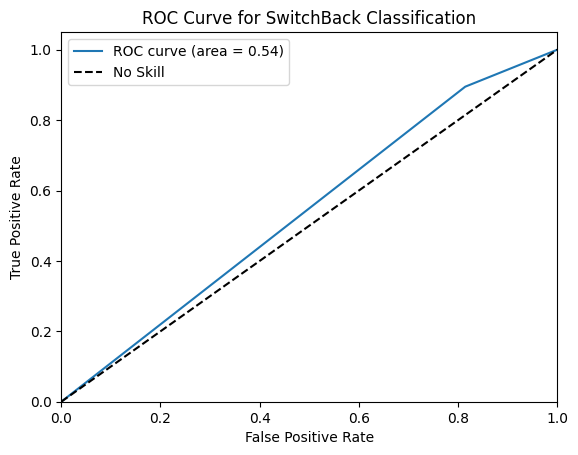

In [ ]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SwitchBack Classification')
plt.legend()
plt.show()

PRC CURVE

In [ ]:
precision, recall, thresholds = precision_recall_curve(test_labels, y_pred)
auc_score = auc(recall, precision)

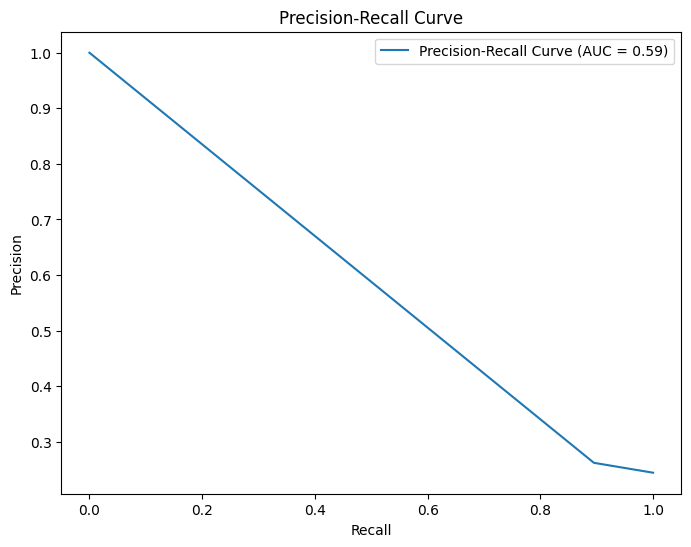

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
#use this if you want to play around with the optional datasets
#probs_pred = model4.predict(eval_features_new, batch_size = 1024)
#p_pred = probs_pred.flatten()



121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


additional plots to use if you choose to do so

training history plot

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'precision', 'recall', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

Confusion Matrix plot

In [ ]:
def plot_cm(labels, predictions, threshold=0.6):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print(' (True Negatives): ', cm[0][0])
  print(' (False Positives): ', cm[0][1])
  print('(False Negatives): ', cm[1][0])
  print(' (True Positives): ', cm[1][1])
  print('Total  SB: ', np.sum(cm[1]))

**Final notes to user: Now that you know how to train ParkerNet, you may retrain ParkerNet with different data. Just make sure the variables, variable order, and time resolution are the same as in this notebook. **